In [190]:
import os, sys
import numpy as np
from astropy import units
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.optimize import minimize
from lightkurve.lightcurve import LightCurve
from scipy.signal import find_peaks, gaussian
from scipy.interpolate import interp1d

import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt

from stella.utils import flare_lightcurve

%load_ext autoreload
%autoreload 2
sys.path.append('/Users/arcticfox/Documents/GitHub/cos_flares/src/')
from utils import *
from cos_flares import FlaresWithCOS

## PROPOSAL ID 16164
plt.rcParams['font.size']=18

rootname = ['lebb01s7q', 'lebb01sbq', 'lebb01sdq', 'lebb01siq', 'lebb01smq']
times = np.load('/Users/arcticfox/Documents/AUMic/reduced/times.npy')
orbits = np.load('/Users/arcticfox/Documents/AUMic/reduced/orbits.npy')

w, f, e = load_binned_data('/Users/arcticfox/Documents/AUMic/reduced/binned_data.npy')
w = np.full(f.shape, w)
parula = np.load('/Users/arcticfox/parula_colors.npy')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fwc = FlaresWithCOS(wavelength=w, flux=f,
                    flux_err=e, time=times, orbit=orbits)
fwc.load_line_table(path='/Users/arcticfox/Documents/GitHub/cos_flares/')
fwc.load_lsf_model(fname='/Users/arcticfox/Documents/AUMic/aa_LSFTable_G130M_1222_LP4_cn.dat')

In [3]:
tpeak = 12455.942687932402
oot = (fwc.orbit == 2) & (fwc.time.value<tpeak-200)
it = np.where((fwc.orbit==2) & (fwc.time.value > tpeak-100))[0]
template = np.nanmean(fwc.flux[oot,:], axis=0)

scaling = 10**11
residuals = np.zeros(fwc.flux[it,:].shape)
for i in tqdm_notebook(range(len(it))):
    residuals[i] = (fwc.flux[it[i]]*scaling) - (template*scaling)

## Comparing peak in all in-flare spectra to out-of-flare spectra

(-0.0008690496313166756, 0.0840679078488189)

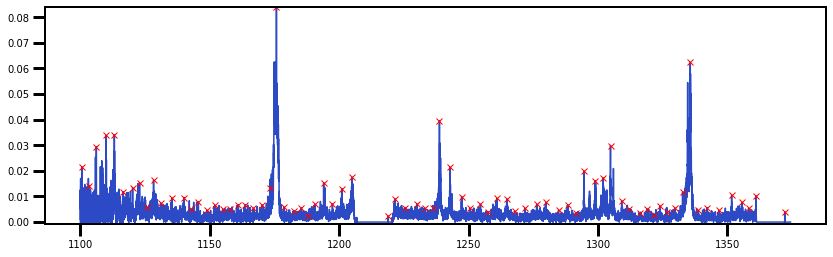

In [4]:
pc = np.load('/Users/arcticfox/parula_colors.npy')[np.linspace(0,210,len(fwc.flux),dtype=int)]
max_template = np.nanmax(fwc.flux[it,:], axis=0)
r = (max_template*scaling) - (template*scaling)
plt.figure(figsize=(14,4))
plt.plot(fwc.wavelength[0][fwc.wavelength[0]>1100],
         r[fwc.wavelength[0]>1100], c=pc[i])
peaks, _ = find_peaks(r[fwc.wavelength[0]>1100], distance=150)
plt.plot(fwc.wavelength[0][fwc.wavelength[0]>1100][peaks],
         r[fwc.wavelength[0]>1100][peaks], 'rx')
plt.ylim(np.nanmin(r[fwc.wavelength[0]>1100]),
         np.nanmax(r[fwc.wavelength[0]>1100]))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


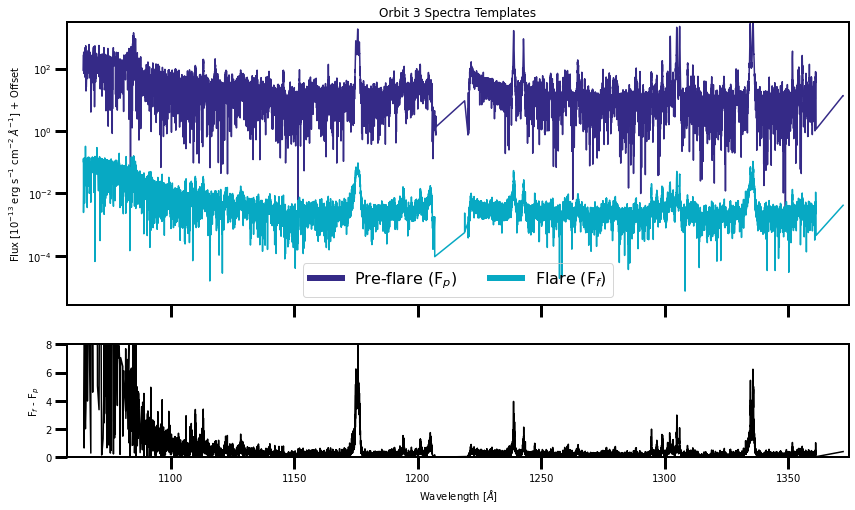

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(14,8), 
                               gridspec_kw={'height_ratios':[2.5,1]},
                               sharex=True)
scaling = 10**-13
fig.set_facecolor('w')
ax1.plot(fwc.wavelength[0][template>0], 
         template[template>0]/scaling*1000, color=parula[0])
ax1.plot(fwc.wavelength[0][max_template>0], 
         max_template[max_template>0]/scaling/100, color=parula[100])
ax1.set_title('Orbit 3 Spectra Templates')
ax1.plot(np.ones(10), np.ones(10), c=parula[0], label='Pre-flare (F$_{p}$)', lw=6)
ax1.plot(np.ones(10), np.ones(10), c=parula[100], label='Flare (F$_{f}$)', lw=6)

#bb_flare = blackbody(wavelength*units.AA, 100000*units.K)
#ax1.plot(wavelength, bb/np.nanmedian(bb), 'k')

ax1.legend(ncol=2, fontsize=16, markerscale=3)
ax1.set_yscale('log')
ax1.set_xlim(np.nanmin(fwc.wavelength[0]), np.nanmax(fwc.wavelength[0]))
ax1.set_ylim(-4,3000)

mask = (max_template>0) & (template>0)

ax2.plot(fwc.wavelength[0][mask], 
         (max_template[mask]/scaling-template[mask]/scaling),#/10**-13,
         'k')
ax2.set_ylim(0,8)
ax2.set_xlabel(r'Wavelength [$\AA$]')
ax2.set_ylabel('F$_{f}$ - F$_{p}$')
ax1.set_ylabel('Flux [$10^{-13}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$] + Offset');

#plt.savefig('spectra_residuals.png', dpi=250, rasterize=True, bbox_inches='tight')

## Line fitting

In [229]:
%load_ext autoreload
%autoreload 2
sys.path.append('/Users/arcticfox/Documents/GitHub/cos_flares/src/')
from cos_flares import FlaresWithCOS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[1.24278947e+03 1.00000000e-01 1.35847135e+00 1.16989183e+01
 9.81312037e+01]
[1.24278847e+03 1.27078230e-01 1.77715387e+00 1.36824382e+01
 9.59494018e+01]


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later


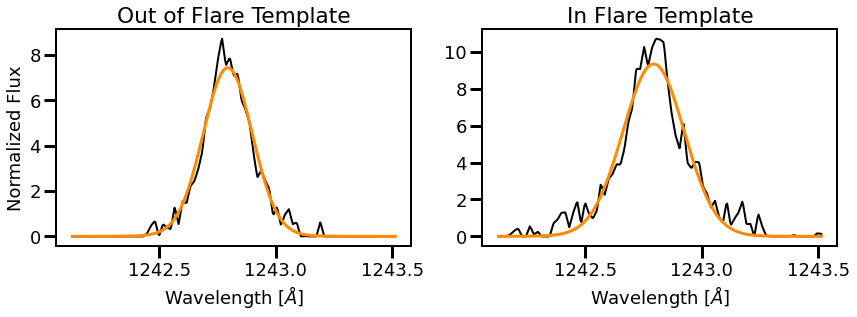

In [231]:
mask = np.where((fwc.orbit == 2) & (fwc.time.value<tpeak-200))[0]
w_oof, f_oof, ferr_oof, m_oof = fwc.model_line_shape('NV_2', mask)

mask = np.where((fwc.orbit == 2) & (fwc.time.value>=tpeak))[0]
w, f, ferr, m = fwc.model_line_shape('NV_2', mask)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
fig.set_facecolor('w')

ax1.plot(w_oof, f_oof, 'k', lw=2)
ax1.plot(w_oof, m_oof, 'darkorange', lw=3)

ax2.plot(w, f, 'k', lw=2)
ax2.plot(w, m, 'darkorange', lw=3)

ax1.set_ylabel('Normalized Flux')
ax1.set_xlabel('Wavelength [$\AA$]')
ax2.set_xlabel('Wavelength [$\AA$]')

ax1.set_title('Out of Flare Template')
ax2.set_title('In Flare Template')

plt.savefig('/Users/arcticfox/Documents/AUMic/figures/profiles.png', dpi=300,
            rasterize=True, bbox_inches='tight')

In [215]:
ion = 'NV_2'
velocity = np.zeros(fwc.wavelength.shape)
masks = np.ones(fwc.wavelength.shape)
wc = fwc.line_table[fwc.line_table['ion']==ion]['wave_c'][0]
for i in range(len(fwc.wavelength)):
    v, _ = fwc.to_velocity(fwc.wavelength[i], wc)
    velocity[i] = v + 0.0
    reg = np.where((v.value>=fwc.line_table[fwc.line_table['ion']==ion]['vmin']-80) &
                   (v.value<=fwc.line_table[fwc.line_table['ion']==ion]['vmax']+80))[0]
    masks[i][reg] = 0 

In [216]:
oot = (fwc.orbit == 2) & (fwc.time.value<tpeak-200)
it = np.where((fwc.orbit==2) & (fwc.time.value > tpeak-100))[0]

oot_template = np.nanmedian(fwc.flux[oot,:],axis=0)[masks[0]==0]
it_template = np.nanmedian(fwc.flux[it,:],axis=0)[masks[0]==0]

f_oot = interp1d(fwc.wavelength[0,reg],oot_template)
f_it = interp1d(fwc.wavelength[0,reg], it_template)

In [217]:
def gaussian(x, mu, std, f):
    exp = -0.5 * (x-mu)**2/(std**2)
    return f/(std * np.sqrt(np.pi * 2.0)) * np.exp(exp)

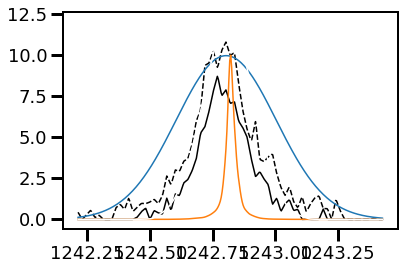

In [226]:
argmin = np.argmin(np.abs([float(i) for i in fwc.lsf_table.colnames] - wc))
m = fwc.lsf_table[fwc.lsf_table.colnames[argmin]].data

finer_wavelength = np.linspace(fwc.wavelength[0,reg][0], 
                               fwc.wavelength[0,reg][-1],
                               len(m))

oot_template = f_oot(finer_wavelength)/1e-14
it_template = f_it(finer_wavelength)/1e-14


mu = wc + 0.0
normalization = 5#np.nanmax(m)
std = 0.2

g = gaussian(finer_wavelength, mu, std, normalization)#*normalization

plt.plot(finer_wavelength, oot_template,'k')
plt.plot(finer_wavelength, it_template,'k--')

conv = np.convolve(m*10, g)
f_conv = interp1d(np.linspace(fwc.wavelength[0,reg][0], 
                              fwc.wavelength[0,reg][-1], len(conv)), 
                  conv)

plt.plot(finer_wavelength, g)
plt.plot(finer_wavelength, m*10)

plt.plot(np.linspace(fwc.wavelength[0,reg][0], 
                              fwc.wavelength[0,reg][-1], len(conv)), 
         conv/100, 'w')

plt.show()

In [ ]:
len(g), len(m)